# 基于线性回归的ML时序分析方法
## 思路
1. 假设每个发动机的生命值HP呈线性衰减，即
$$hp(t)=1-\lambda t$$
2. 根据发动机$J_i$的最终寿命$T_i$计算出$\lambda_i$，即
$$\lambda_i=\dfrac{1}{T_i}$$
3. 为训练集中飞行历史的每个样本赋值，对于发动机$J_i$的第$k$次飞行，有
$$hp_{J_i}(k)=1-\lambda_i k$$
4. 对训练样本进行划分，分为训练集$S_{Test}$以及验证集$S_{Validation}$
5. 设计神经网络（可以是CNN，LTSM，RNN等）
6. 训练神经网络（训练样本是否包含前三列数据是个问题，可考虑对比实验）
7. 根据模型predict测试集$S_{Test}$中各个测试样本的生命值，并线性拟合求斜率$\hat\lambda$
8. 剩余寿命为
$$ RUL = \dfrac{1}{\hat\lambda}-n$$
其中$n$为当前飞行次数。

## 可能存在的问题
1. 使用哪些传感器的数据用来训练
2. 是否需要standardize数据 
```python
from sklearn.preprocessing import StandardScaler
```

In [2]:
# 首先数据清洗
import pandas as pd


def data_clean():
    jet = pd.read_table('train_data.txt', sep=' ', header=None)
    jet.drop([26, 27], axis=1, inplace=True)
    jet_index_1 = jet.iloc[:, 0].tolist()
    jet_index_2 = jet.iloc[:, 1].tolist()
    jet_index = pd.MultiIndex.from_arrays(
        [jet_index_1, jet_index_2], names=['id', 'flight'])
    jet.set_index(jet_index, inplace=True)
    jet.drop([0, 1], axis=1, inplace=True)
    sensors = '''Altitude
    Mach #
    Power Setting (TRA)
    12 Total temperature at fan inlet°R
    T24 Total temperature at LPC outlet °R
    T30 Total temperature at HPC outlet °R
    T50 Total temperature at LPT outlet °R
    P2 Pressure at fan inlet psia
    P15 Total pressure in bypass-duct psia
    P30 Total pressure at HPC outlet psia
    Nf Physical fan speed rpm
    Nc Physical core speed rpm
    epr Engine pressure ratio (P50/P2) -
    Ps30 Static pressure at HPC outlet psia
    phi Ratio of fuel flow to Ps30 pps/psi
    NRf Corrected fan speed rpm
    NRc Corected core speed rpm
    BPR Bypass Ratio-
    farB Bumer fuel-air ratio
    htBleed (Bleed Enthalpy)
    Nf_dmd Demanded fan speed rpm
    PCNFR_dmd Demanded corre dted fan speed rpm
    w31 HPT cool ant bleed lbm/s
    w32 LPT coolant bleed lbm/s'''
    sensors = sensors.split(sep='\n')
    num_col = list(range(1, 25))
    jet.columns = num_col
    sensors_dict = dict(zip(num_col, sensors))
    return jet, sensors_dict


jet, sensors = data_clean()

TOTAL = 260

In [3]:
jet.head()

1       2      3       4       5        6        7     8   \
id flight                                                                   
1  1       34.9983  0.8400  100.0  449.44  555.32  1358.61  1137.23  5.48   
   2       41.9982  0.8408  100.0  445.00  549.90  1353.22  1125.78  3.91   
   3       24.9988  0.6218   60.0  462.54  537.31  1256.76  1047.45  7.05   
   4       42.0077  0.8416  100.0  445.00  549.51  1354.03  1126.38  3.91   
   5       25.0005  0.6203   60.0  462.54  537.07  1257.71  1047.93  7.05   

             9       10   ...        15       16       17       18    19   20  \
id flight                 ...                                                   
1  1       8.00  194.64   ...    183.06  2387.72  8048.56   9.3461  0.02  334   
   2       5.71  138.51   ...    130.42  2387.66  8072.30   9.3774  0.02  330   
   3       9.02  175.71   ...    164.22  2028.03  7864.87  10.8941  0.02  309   
   4       5.71  138.46   ...    130.72  2387.61  8068.66   9.3528  0.02  329   
   5       9.03  175.05   ...    164.31  2028.00  7861.23  10.8963  0.02  309   

             21      22     23      24  
id flight                               
1  1       2223  100.00  14.73  8.8071  
   2       2212  100.00  10.41  6.2665  
   3       1915   84.93  14.08  8.6723  
   4       2212  100.00  10.59  6.4701  
   5       1915   84.93  14.13  8.5286  

[5 rows x 24 columns]

In [4]:
norm_jet = (jet - jet.min())/(jet.max()-jet.min())

In [5]:
life_span = [len(jet.loc[i]) for i in range(1,261)]  # 注意 list索引 = df索引-1

In [6]:
import numpy as np
np.random.seed(2000)

In [7]:
jet_index = np.array(jet.index)

In [8]:
hp = [1-index[1]/life_span[index[0]-1] for index in jet_index]

In [9]:
jet['hp'] = hp
norm_jet['hp']=hp

In [10]:
norm_jet.head()

1         2    3         4         5         6         7  \
id flight                                                                    
1  1       0.833134  0.997625  1.0  0.060269  0.181576  0.311201  0.273095   
   2       0.999767  0.998575  1.0  0.000000  0.131847  0.296600  0.245535   
   3       0.595096  0.738480  0.0  0.238089  0.016332  0.035297  0.056997   
   4       0.999993  0.999525  1.0  0.000000  0.128269  0.298795  0.246979   
   5       0.595137  0.736698  0.0  0.238089  0.014130  0.037871  0.058152   

                  8         9        10    ...           16        17  \
id flight                                  ...                          
1  1       0.146592  0.144025  0.138036    ...     0.992394  0.476508   
   2       0.000000  0.000000  0.004081    ...     0.992229  0.533013   
   3       0.293184  0.208176  0.092860    ...     0.001157  0.039296   
   4       0.000000  0.000000  0.003962    ...     0.992091  0.524349   
   5       0.293184  0.208805  0.091284    ...     0.001075  0.030633   

                 18   19        20        21   22        23        24  \
id flight                                                               
1  1       0.369947  0.0  0.322917  0.651163  1.0  0.156036  0.159082   
   2       0.381407  0.0  0.281250  0.627907  1.0  0.007888  0.014562   
   3       0.936731  0.0  0.062500  0.000000  0.0  0.133745  0.151414   
   4       0.372400  0.0  0.270833  0.627907  1.0  0.014060  0.026144   
   5       0.937537  0.0  0.062500  0.000000  0.0  0.135460  0.143240   

                 hp  
id flight            
1  1       0.993289  
   2       0.986577  
   3       0.979866  
   4       0.973154  
   5       0.966443  

[5 rows x 25 columns]

In [11]:
import keras

Using TensorFlow backend.


In [12]:
jet_x = np.array(norm_jet)[:,:24]

In [13]:
jet_y = np.array(hp)

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [17]:
def baseline_model():
    model = Sequential()
    model.add(Dense(12,input_shape=(24,),activation='relu'))
    model.add(Dense(6,activation='relu'))    
    model.add(Dense(6,activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [19]:
estimator = KerasRegressor(build_fn=baseline_model)

In [20]:
history = estimator.fit(jet_x,jet_y,batch_size=10, epochs=50, validation_split=0.3,verbose=1)

Train on 37631 samples, validate on 16128 samples
Epoch 1/50
37631/37631 [==============================] - 5s 123us/step - loss: 0.0771 - val_loss: 0.0565
Epoch 2/50
37631/37631 [==============================] - 4s 99us/step - loss: 0.0369 - val_loss: 0.0301
Epoch 3/50
37631/37631 [==============================] - 4s 102us/step - loss: 0.0319 - val_loss: 0.0379
Epoch 4/50
37631/37631 [==============================] - 4s 101us/step - loss: 0.0311 - val_loss: 0.0295
Epoch 5/50
37631/37631 [==============================] - 4s 99us/step - loss: 0.0301 - val_loss: 0.0270
Epoch 6/50
37631/37631 [==============================] - 4s 101us/step - loss: 0.0294 - val_loss: 0.0268
Epoch 7/50
37631/37631 [==============================] - 4s 100us/step - loss: 0.0290 - val_loss: 0.0368
Epoch 8/50
37631/37631 [==============================] - 4s 100us/step - loss: 0.0289 - val_loss: 0.0274
Epoch 9/50
37631/37631 [==============================] - 4s 102us/step - loss: 0.0284 - val_loss: 0.034

In [23]:
import matplotlib.pyplot as plt

In [68]:
def plot_predict(jet_id):
    data = np.array(norm_jet.drop('hp',axis=1).loc[jet_id])
    result = estimator.predict(data)
    plt.plot(result)
    plt.savefig(str(jet_id))
    plt.show()
#     plt.scatter(range(len(result)),result)

In [70]:
def scatter_predict(jet_id):
    data = np.array(norm_jet.drop('hp',axis=1).loc[jet_id])
    result = estimator.predict(data)
    plt.scatter(range(len(result)),result)    
    plt.savefig('scatter '+str(jet_id))
    plt.show()


In [57]:
sample = np.random.sample(10)*200
sample = sample.astype(int)
sample

array([196,  73,  40, 137, 146, 142, 195,  65, 149, 173])

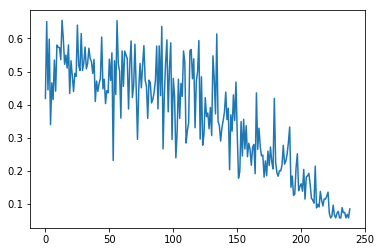

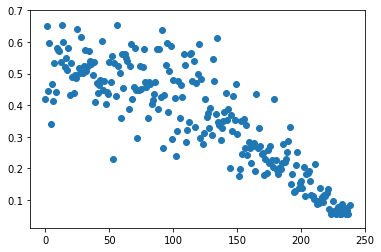

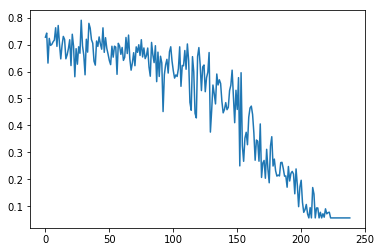

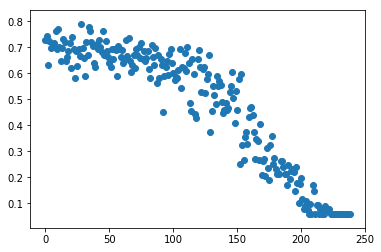

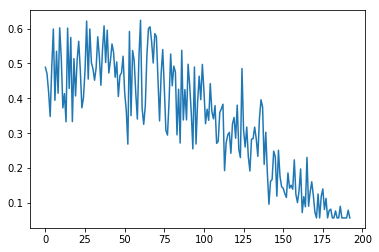

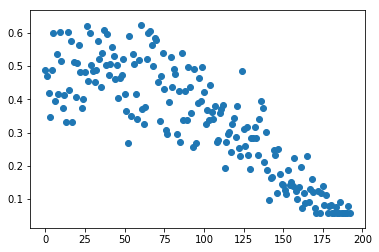

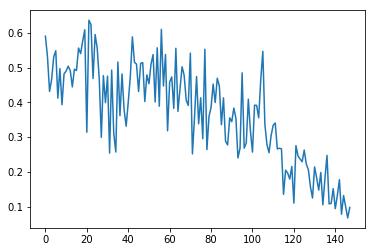

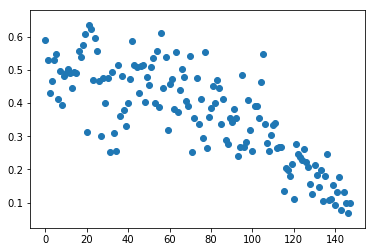

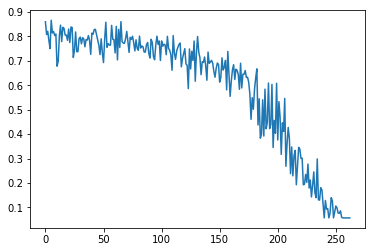

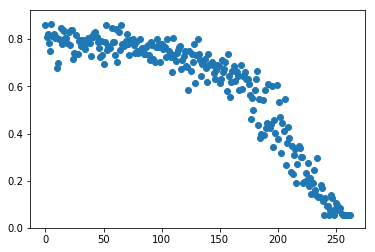

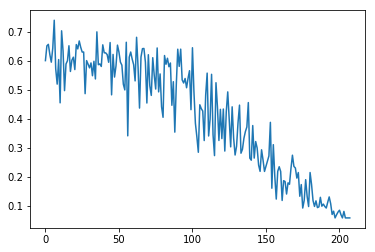

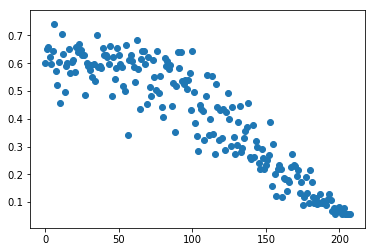

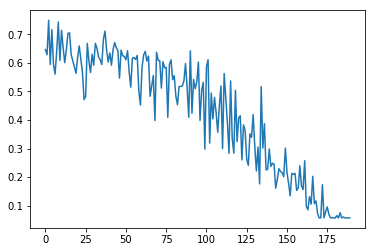

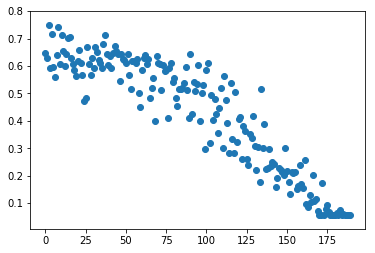

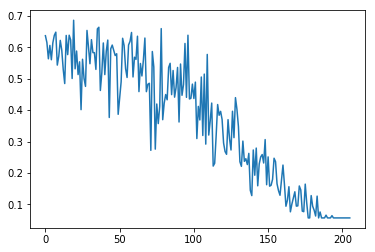

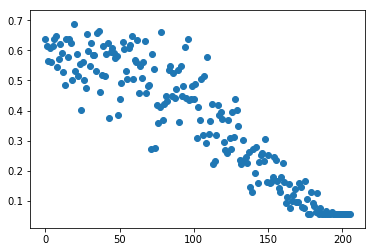

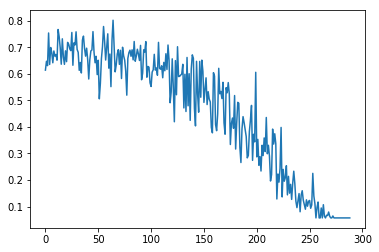

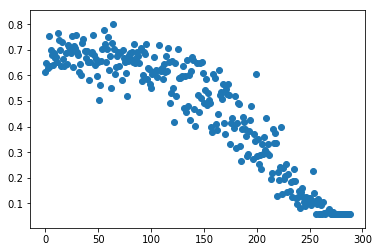

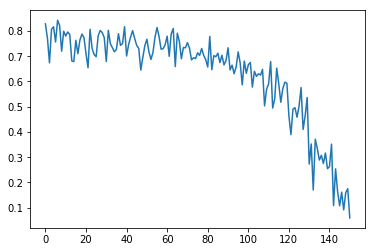

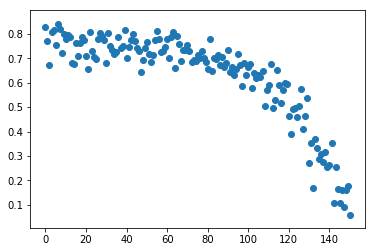

In [71]:
for i in sample:
    visualize_predict(i)
    scatter_predict(i)

# 基于指数回归的ML时序分析方法
## 思路
1. 假设每个发动机的生命值HP呈指数衰减，即
$$hp(t)=2-e^{\lambda t}$$
2. 根据发动机$J_i$的最终寿命$T_i$计算出$\lambda_i$，即
$$\lambda_i=\dfrac{\ln 2}{T_i}$$
3. 为训练集中飞行历史的每个样本赋值，对于发动机$J_i$的第$k$次飞行，有
$$hp_{J_i}(k)=2-e^{\lambda k}$$
4. 对训练样本进行划分，分为训练集$S_{Test}$以及验证集$S_{Validation}$
5. 设计神经网络（可以是CNN，LTSM，RNN等）
6. 训练神经网络（训练样本是否包含前三列数据是个问题，可考虑对比实验）
7. 根据模型predict测试集$S_{Test}$中各个测试样本的生命值，并线性拟合求斜率$\hat\lambda$
8. 剩余寿命为
$$ RUL = \dfrac{\ln 2}{\hat\lambda}-n$$
其中$n$为当前飞行次数。